In [4]:
import numpy as np
import scipy.stats as sps
from glob import glob
import uproot as ur
import ROOT as rt
import ROOT.RooFit as rf
from scipy.special import erf
from histo_utilities import create_TH1D, create_TH2D, std_color_list
from cebefo_style import Set_2D_colz_graphics
from particle import Particle

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

donotdelete = []

In [5]:
import operator
ops = {'>': operator.gt, '<': operator.lt, }

In [6]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [28]:
m_D0 = 1e-3*Particle.from_string('D0').mass
print m_D0
m_Dst = 1e-3*Particle.from_string('D*+').mass
print m_Dst
m_B0 = 1e-3*Particle.from_string('B0').mass
print m_B0
m_pi = 1e-3*Particle.from_string('pi+').mass
print 'mD* - mD0 =', m_Dst - m_D0

1.86483
2.01026
5.27963
mD* - mD0 = 0.14543


In [8]:
def drawOnCMSCanvas(dobj, opt = None, tag=''):
    c = rt.TCanvas('c'+tag, 'c'+tag, 50, 50, 800, 600)
    c.SetTickx(0)
    c.SetTicky(0)
    
    if dobj.__class__ == rt.RooPlot:
        dobj.Draw()
    elif dobj[0].__class__ in [rt.TH1D, rt.TH2D]:
        for i, o in enumerate(dobj):
            do = ''
            if not (opt is None):
                if opt == 'same':
                    if i>0:
                        do = 'SAME'
                else:
                    do = opt[i]
            o.Draw(do)
    else:
        print 'Class not recognized'
        raise
        
    
    CMS_lumi.CMS_lumi(c, -1, 0)
    c.obj = dobj
    c.Draw()
    return c

In [9]:
def extarct(t, branches = []):
    if len(branches) == 0:
        branches = t.keys()
    l = {}
    for k in branches:
        print 'Loading branch', k
        m = []
        for i, e in enumerate(t.array(k)):
            m += list(e)
        l[k] = np.array(m)
    
    return l

In [10]:
def extarct_multiple(fname, branches = []):
    if len(branches) == 0:
        print 'Must give a branches list'
    l = {}
    for b in branches:
        l[b] = []
    
    flist = glob(fname)
    
    for i,f in enumerate(flist):
        t = ur.open(f)
        if 'outA;1' in t.keys():
            t=t['outA']['Tevts']
            for k in branches:
                
                for i, e in enumerate(t.array(k)):
                    l[k] += list(e)
    
    for b in branches:
        l[b] = np.array(l[b])
    return l

In [11]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [14]:
tMC = ur.open('../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_SoftQCD_PTFilter5_0p0-evtgen_HQET2_central_PU35_10-2-3_v0/B02DstMu_candidates.root')['outA']['Tevts']
print tMC.keys(), '\n\n'
branches = tMC.keys()[10:]
for b in np.sort(branches):
    print b

['n_B', 'n_D0', 'n_Dst', 'n_K', 'n_pi', 'n_pis', 'trgMu_charge', 'trgMu_eta', 'trgMu_phi', 'trgMu_pt', 'B_E', 'B_P', 'B_eta', 'B_phi', 'B_pt', 'D0_E', 'D0_P', 'D0_eta', 'D0_phi', 'D0_pt', 'Dst_E', 'Dst_P', 'Dst_eta', 'Dst_phi', 'Dst_pt', 'Est_mu', 'K_E', 'K_P', 'K_eta', 'K_phi', 'K_pt', 'M2_miss', 'chi2_D0pis', 'chi2_MuDst', 'chi2_kpi', 'cos_D0pis_vtxMu', 'cos_MuDst_vtxMu', 'cos_kpi_vtxMu', 'd_vtxD0pis_vtxMu', 'd_vtxkpi_vtxMu', 'dca_D0pis_vtxMu', 'dca_kpi_vtxMu', 'mass_D0pis', 'mass_MuDst', 'mass_kpi', 'pi_E', 'pi_P', 'pi_eta', 'pi_phi', 'pi_pt', 'pis_E', 'pis_P', 'pis_eta', 'pis_phi', 'pis_pt', 'q2', 'sigd_vtxD0pis_vtxMu', 'sigd_vtxkpi_vtxMu', 'sigdca_D0pis_vtxMu', 'sigdca_kpi_vtxMu'] 


B_E
B_P
B_eta
B_phi
B_pt
D0_E
D0_P
D0_eta
D0_phi
D0_pt
Dst_E
Dst_P
Dst_eta
Dst_phi
Dst_pt
Est_mu
K_E
K_P
K_eta
K_phi
K_pt
M2_miss
chi2_D0pis
chi2_MuDst
chi2_kpi
cos_D0pis_vtxMu
cos_MuDst_vtxMu
cos_kpi_vtxMu
d_vtxD0pis_vtxMu
d_vtxkpi_vtxMu
dca_D0pis_vtxMu
dca_kpi_vtxMu
mass_D0pis
mass_MuDst
mass_kpi
pi

In [15]:
fn = '../data/cmsMC_private/BPH_Tag-B0_MuNuDmst-pD0bar-kp_13TeV-pythia8_SoftQCD_PTFilter5_0p0-evtgen_HQET2_central_PU35_10-2-3_v0'
fn += '/B02DstMu_candidates/out*.root'
dMC = extarct_multiple(fn, branches=branches)
print 'Number of candidates:', dMC['mass_kpi'].shape[0]

Number of candidates: 6601


In [34]:
fn = '../data/cmsMC_private/BPH_Tag-B0_TauNuDmst-pD0bar-kp-t2mnn_pythia8_SoftQCD_PTFilter5_0p0-evtgen_HQET2_central_NoPU_10-2-3_v0'
fn += '/B02DstMu_candidates/out*.root'
dMC_tau = extarct_multiple(fn, branches=branches)
print 'Number of candidates:', dMC_tau['mass_kpi'].shape[0]

Number of candidates: 3990


In [16]:
# fn = '../data/cmsRD/Run2018D/MuDst_candidates/out*.root'
# dRD = extarct_multiple(fn, branches)
# print 'Number of candidates:', dRD['mass_kpi'].shape[0]

# Cuts declaration

In [17]:
cut = {}
cut['cos_D0pis_vtxMu'] = ['>', 0.95]
cut['chi2_D0pis'] = ['<', 3.84]
# cut['d_vtxkpi_vtxMu'] = ['>', 0.03]
# cut['sigdca_kpi_vtxMu'] = ['>', 2.]

In [19]:
np.max(dMC['chi2_D0pis'])

6.634117

In [50]:
sps.chi2.cdf(3.84, 1)

0.9499564787512949

In [20]:
def createSel(d, cut):
    sel = np.ones_like(d[cut.keys[0]], dtype=bool)
    for k, v in cut.iteritems():
        sel = np.logical_and(sel, ops[v[0]](d[k], v[1]) )
    return sel

## MC only

In [21]:
dMC['mass_D0pis']

array([2.0098155, 2.0101278, 2.010078 , ..., 2.0095112, 2.009462 ,
       2.0111952], dtype=float32)

<ROOT.TLine object ("TLine") at 0x7fecb3bcb240>

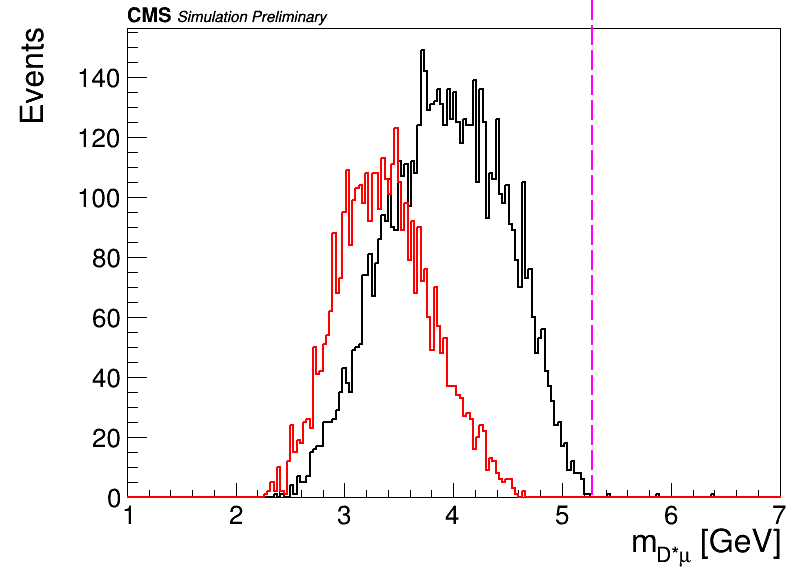

In [45]:
h = create_TH1D(dMC['mass_MuDst'], axis_title=['m_{D*#mu} [GeV]', 'Events'], binning=[200,1,7])
h_tau = create_TH1D(dMC_tau['mass_MuDst'], binning=h.binning)
h_tau.SetLineColor(2)
CMS_lumi.extraText = "     Simulation Preliminary"
c = drawOnCMSCanvas([h, h_tau], 'same')
cl.DrawLine(m_B0, 0, m_B0, 1800)

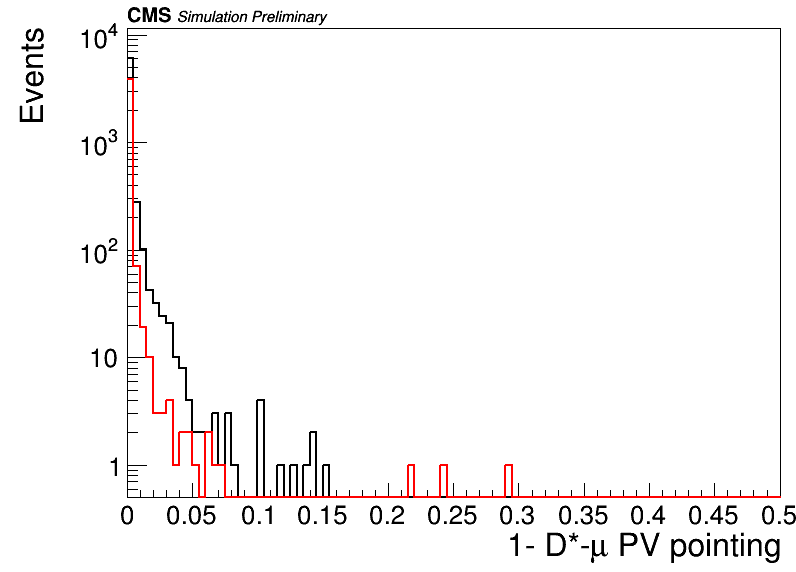

In [42]:
h = create_TH1D(1-dMC['cos_MuDst_vtxMu'], axis_title=['1- D*-#mu PV pointing', 'Events'], binning=[100,0.,0.5])
h_tau = create_TH1D(1-dMC_tau['cos_MuDst_vtxMu'], binning=h.binning)
h_tau.SetLineColor(2)
CMS_lumi.extraText = "     Simulation Preliminary"
c = drawOnCMSCanvas([h, h_tau], 'same')
c.SetLogy()

In [61]:
binning_q2 = np.linspace(-0.4, 12.6, 5, True)
N_q2bins = binning_q2.shape[0]-1
print binning_q2

binning = {}
binning['M2_miss'] = [40/5, -2, 10]
binning['Est_mu'] = [30/5, 0.10, 2.500]

xAx_title = {}
xAx_title['M2_miss'] = 'm^{2}_{miss} [GeV^{2}]'
xAx_title['Est_mu'] = 'E*_{#mu} [GeV]'

N_var = len(binning.keys())

def q2_sel(arr, q2_l, q2_h, vname='q2'):
    return np.logical_and(arr[vname] > q2_l, arr[vname] < q2_h)

[-0.4   2.85  6.1   9.35 12.6 ]


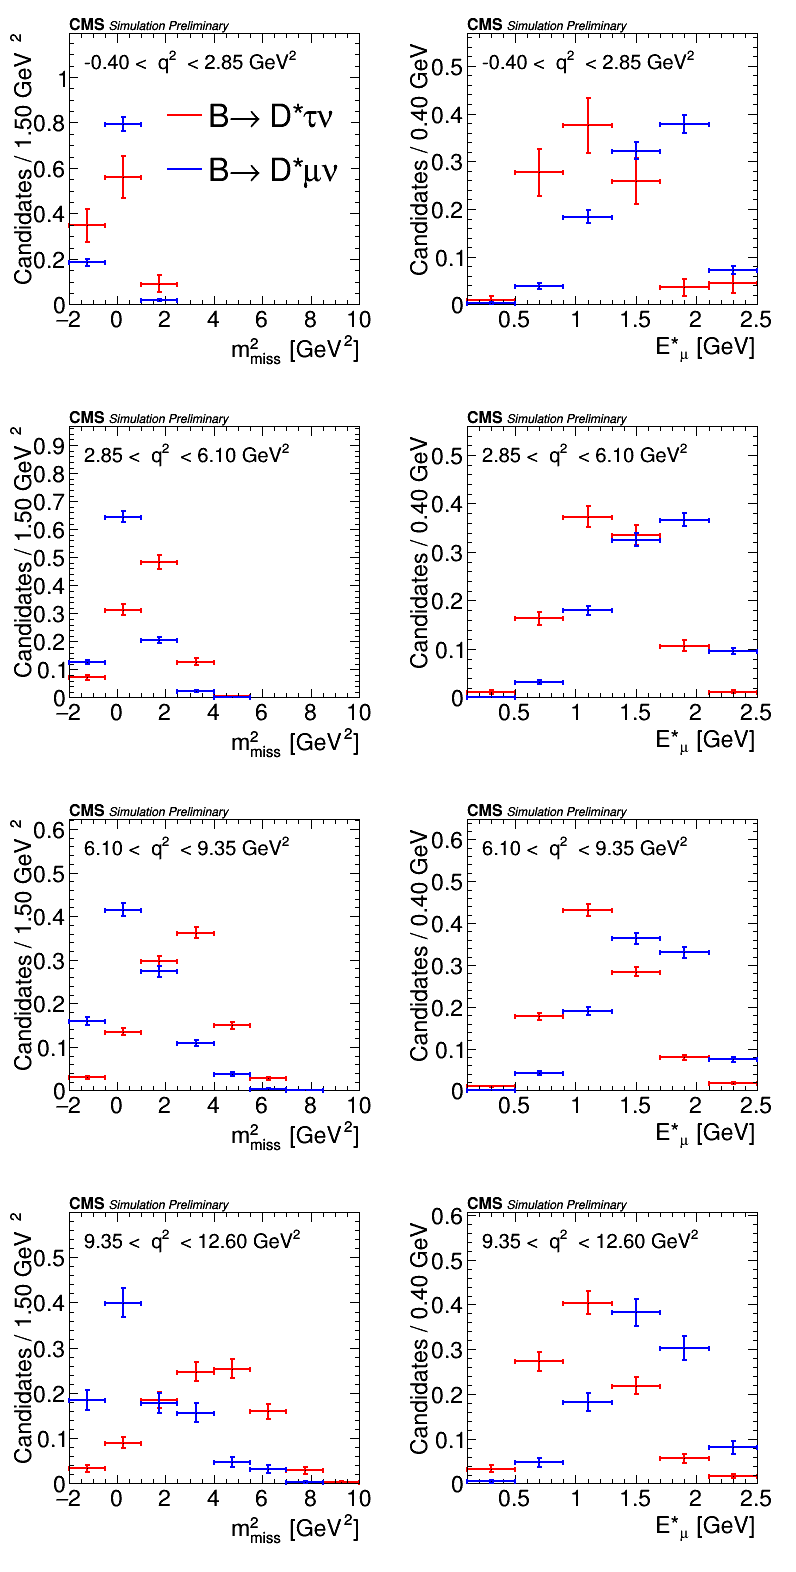

In [68]:
canvas = rt.TCanvas('c_out', 'c_out', 50, 50, N_var*400, 400*N_q2bins)
canvas.SetTickx(0)
canvas.SetTicky(0)
canvas.Divide(N_var, N_q2bins)

CMS_lumi.extraText = "        Simulation Preliminary"

vars_to_plot = ['M2_miss', 'Est_mu']

for i_q2 in range(N_q2bins):
    q2_l = binning_q2[i_q2]
    q2_h = binning_q2[i_q2+1]

    q2_txt = '{:.2f} <  q^{{2}}  < {:.2f} GeV^{{2}}'.format(q2_l, q2_h)

    for i_v, vark in enumerate(vars_to_plot):
        h_bname = 'h_{}_{}'.format(i_q2, i_v)

        h_dic = {}
        for k, t in zip(['mu', 'tau'], [dMC, dMC_tau]):
            aux = t[vark][q2_sel(t, q2_l, q2_h)]
            h_dic[k] = create_TH1D(aux, h_bname+'_aux_'+k, binning=binning[vark])
#             h_dic[k].Scale(overall_scale_factor)

#         h_dic['tau'].Scale(0.3*0.17) #R(D*)*Br(tau->mu)


        h = rt.TH1D(h_bname+'_tau', h_bname+'_tau', binning[vark][0], binning[vark][1], binning[vark][2])
        h.Add(h_dic['tau'])#, h_dic['mu']) #Just because we want to show them separate
        h.SetLineColor(2)
        h.GetXaxis().SetTitle(xAx_title[vark])
        h.GetXaxis().SetTitleSize(0.07)
        h.GetXaxis().SetLabelSize(0.07)
        h.GetYaxis().SetTitleOffset(1.14)
        h.GetXaxis().SetTitleOffset(1.1)
        h.GetYaxis().SetTitleSize(0.07)
        h.GetYaxis().SetLabelSize(0.07)
        iunits = xAx_title[vark].find('[') + 1
        h.GetYaxis().SetTitle('Candidates / {:.2f} '.format(h.GetBinWidth(1)) + xAx_title[vark][iunits:-1])

        h2 = h_dic['mu'].Clone(h_bname+'_mu')
        h2.SetLineColor(4)

        i_pad = i_q2*N_var + i_v + 1
        pad = canvas.cd(i_pad)
        pad.SetBottomMargin(0.2)
        pad.SetRightMargin(0.08)

        # Normalize them to unity....
        h.Scale(1./h.Integral())
        h2.Scale(1./h2.Integral())
        h.GetYaxis().SetRangeUser(0, 1.5*np.max([x.GetMaximum() for x in [h, h2]]))


        h.Draw('E1')
        h2.Draw('E1SAME')

        l = rt.TLatex()
        l.SetTextAlign(11)
        l.SetTextSize(0.06)
        l.SetTextFont(42)
        l.DrawLatexNDC(0.2, 0.85, q2_txt)

        CMS_lumi.CMS_lumi(pad, -1, 0, 0.75*1.3, 0.6*1.3)

        if 'ip' in vark:
            maxs = [x.GetMaximum() for x in [h, h2]]
            h.GetYaxis().SetRangeUser(1e-4, 1.5*np.max(maxs))
            pad.SetLogy()

        if i_pad == 1:
            leg = rt.TLegend(0.4, 0.5, 0.9, 0.8)
            leg.SetTextFont(42)
            leg.SetTextAlign(12)
            leg.SetLineWidth(0)
            leg.SetBorderSize(0)
            leg.AddEntry(h, 'B#rightarrow D*#tau#nu', 'l')
            leg.AddEntry(h2, 'B#rightarrow D*#mu#nu', 'l')
            leg.Draw()

        donotdelete.append([h, h2])

canvas.Draw()

## RD only

Chi2 cut eff: 0.8819751284972989


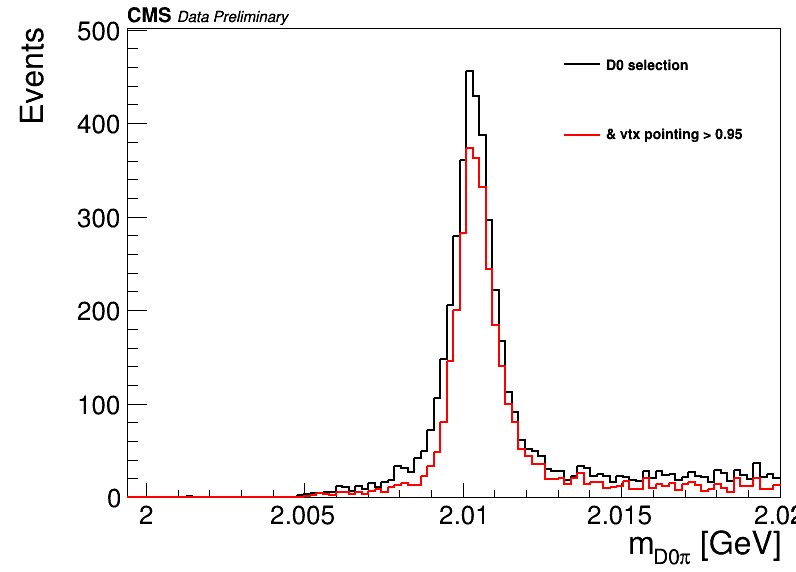

In [55]:
leg = rt.TLegend(0.7,0.7,0.95,0.95)
leg.SetLineWidth(0)
leg.SetBorderSize(0)
leg.SetFillStyle(0)

hl = []
lsel = []

# sel = np.ones_like(dRD['mass_D0pis'], dtype=bool)
sel = dRD['chi2_D0pis'] < cut['chi2_D0pis'][1]
print 'Chi2 cut eff:', np.sum(sel)/float(sel.shape[0])
h = create_TH1D(dRD['mass_D0pis'][sel], axis_title=['m_{D0#pi} [GeV]', 'Events'], binning=[100,m_D0+m_pi-0.005,2.02])
leg.AddEntry(h, 'D0 selection', 'l')
hl.append(h)
lsel.append(sel)

sel = np.logical_and(sel, dRD['cos_D0pis_vtxMu'] > cut['cos_D0pis_vtxMu'][1])
hcut = create_TH1D(dRD['mass_D0pis'][sel], binning=h.binning)
leg.AddEntry(hcut, '& vtx pointing > {:.2f}'.format(cut['cos_D0pis_vtxMu'][1]), 'l')
hcut.SetLineColor(2)
hl.append(hcut)
lsel.append(sel)

CMS_lumi.extraText = "     Data Preliminary"
c = drawOnCMSCanvas(hl, 'same')
hl[0].GetYaxis().SetRangeUser(0, hl[0].GetMaximum()*1.1)
leg.Draw()

Tot histo entries: 4638
[WARNING] Chi2: 174.695863464 / 94
Total: Nsig = 3115, Nbkg = 1525
Sig region histo entries: 3625
Sig region: Nsig = 3106, Nbkg = 609

Tot histo entries: 3378
[WARNING] Chi2: 256.187438215 / 94
Total: Nsig = 2502, Nbkg = 877
Sig region histo entries: 2790
Sig region: Nsig = 2495, Nbkg = 329



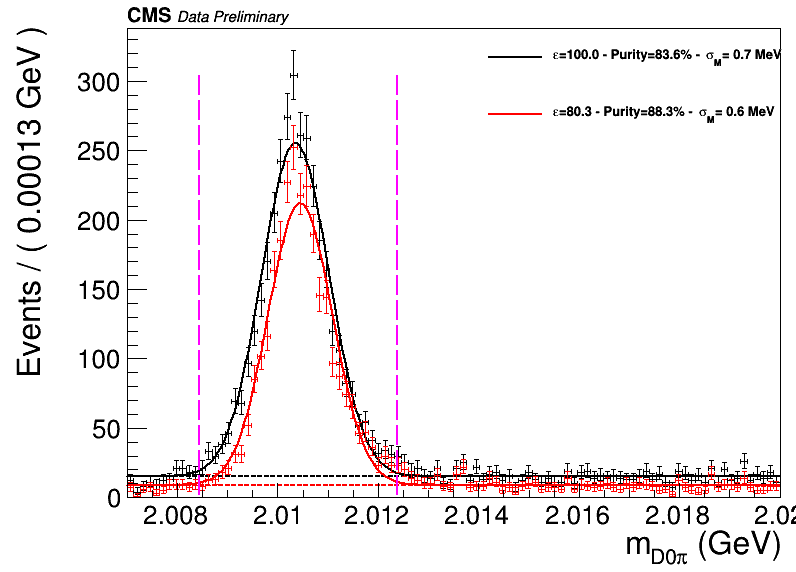

In [63]:
pk_width = 0.04
fit_stop = 0.06

leg = rt.TLegend(0.6,0.75,0.98,0.95)
leg.SetLineWidth(0)
leg.SetBorderSize(0)
leg.SetFillStyle(0)

useRooFit = True

dobj = []
N_sig = []
purity = []

sig_mean = []
sig_sigma = []

binning = [100,2.007,2.02]
m = rt.RooRealVar('m', 'm_{D0#pi}', binning[1], binning[2], 'GeV')
frame = m.frame(rf.Title(""))

for i, h in enumerate(hl):
    h = create_TH1D(dRD['mass_D0pis'][lsel[i]], binning=binning)
    h.SetLineColor(hl[i].GetLineColor())
    h.Sumw2()
    dobj.append(h)
    
    print 'Tot histo entries: {:.0f}'.format(h.Integral(1, h.binning[0]))
    
    if(useRooFit):
        mean = rt.RooRealVar('mean', 'm_{D0}', m_Dst, 0, 5, 'GeV')
        sigma = rt.RooRealVar('sigma', '#sigma', 0.001, 0.00005, 0.05, 'GeV') 
        pdf_sig = rt.RooGaussian('gaus','sig pdf', m, mean, sigma)
        
        nsig = rt.RooRealVar('nsig', 'N_{S}', 3000, 0, 1e6)
        pdf_sig_ext = rt.RooExtendPdf('esig', 'esig', pdf_sig, nsig)
        
#         lam = rt.RooRealVar('lam', '#lambda', -2.1, -100, -0.1, 'GeV^{-1}')
#         pdf_bkg = rt.RooExponential('expo', 'bkg pdf', m, lam)
        a0 = rt.RooRealVar('a0', 'a0', 10, 0, 100)
        a1 = rt.RooRealVar('a1', 'a1', 0.1, -10, 1000)
        a2 = rt.RooRealVar('a2', 'a2', -0.1, -100, 1000)
        pdf_bkg = rt.RooPolynomial('poly', 'bkg pdf', m, rt.RooArgList(a0, a1, a2), 0)
        
        nbkg = rt.RooRealVar('nbkg', 'N_{B}', 0, 1e6)
        pdf_bkg_ext = rt.RooExtendPdf('ebkg', 'ebkg', pdf_bkg, nbkg)
        
        data = rt.RooDataHist('d', 'd', rt.RooArgList(m), h)

        pdf_tot = rt.RooAddPdf('pdftot', 'pdftot', rt.RooArgList(pdf_sig_ext, pdf_bkg_ext))
        pdf_tot.fitTo(data, rt.RooFit.PrintLevel(-1))
        
        chi2 = rt.RooChi2Var("chi2", 'chi2', pdf_tot, data)
        if chi2.getVal() > rt.TMath.ChisquareQuantile(0.95, h.binning[0]-1-5):
            print '[WARNING] Chi2:', chi2.getVal(), '/', h.binning[0]-1-5
            
        print 'Total: Nsig = {:.0f}, Nbkg = {:.0f}'.format(nsig.getVal(), nbkg.getVal())

        data.plotOn(frame, rf.MarkerStyle(1), rf.DrawOption('E1'), rf.MarkerColor(hl[i].GetLineColor()), rf.LineColor(hl[i].GetLineColor()))
        pdf_tot.plotOn(frame, rf.LineColor(hl[i].GetLineColor()), rf.LineWidth(2))
        pdf_tot.plotOn(frame, rf.Components('ebkg'), rf.LineColor(hl[i].GetLineColor()), rf.LineWidth(2), rf.LineStyle(7))
        
        lb = mean.getVal()-3*sigma.getVal()
        hb = mean.getVal()+3*sigma.getVal()
        print 'Sig region histo entries: {:.0f}'.format(h.Integral(h.FindBin(lb), h.FindBin(hb)))
#         m.setRange("signal", lb, hb)
#         fsigregion_bkg = pdf_bkg.createIntegral(rt.RooArgSet(m), rf.NormSet(rt.RooArgSet(m)), rf.Range("signal"))
#         fsigregion_sig = pdf_sig.createIntegral(rt.RooArgSet(m), rf.NormSet(rt.RooArgSet(m)), rf.Range("signal"))

#         Nsig = fsigregion_sig.getVal()*nsig.getVal()
#         Nbkg = fsigregion_bkg.getVal()*nbkg.getVal()
        
        l = lam.getVal()
        expInt = (np.exp(l*lb) - np.exp(l*hb))/(np.exp(l*binning[1]) - np.exp(l*binning[2]))
        Nbkg = expInt * nbkg.getVal()
        Nsig = erf(3/np.sqrt(2)) * nsig.getVal()
        print 'Sig region: Nsig = {:.0f}, Nbkg = {:.0f}\n'.format(Nsig, Nbkg)
        
        N_sig.append(Nsig)
        purity.append(Nsig/float(Nbkg+Nsig))
        
        sig_mean.append(mean.getVal())
        sig_sigma.append(sigma.getVal())
        
        leg.AddEntry(h, '#varepsilon={:.1f} - Purity={:.1f}% - #sigma_{{M}}= {:.1f} MeV'.format(100*Nsig/N_sig[0], purity[-1]*100, 1e3*sigma.getVal()), 'l')

    else:
        if i == 0:
            fun = 'expo'
        else:
            fun = 'expo'

        f = rt.TF1('bkg', fun, h.binning[1], h.binning[2])
        f.SetLineColor(hl[i].GetLineColor())
        f.SetLineStyle(9)
        r = h.Fit(f, 'LSNQ', '', h.binning[1], m_D0-fit_stop).Get()
        if r.Prob() < 0.05:
            print '[WARNING]: Bad fit fot histo N', i
        dobj.append(f)

        n_start = h.FindBin(m_D0-pk_width)
        n_stop = h.FindBin(m_D0+pk_width)

        Nsig = 0
        Ntot = 0
        for n in range(n_start, n_stop+1):
            Nsig += h.GetBinContent(n) - f.Eval(h.GetBinCenter(n))
            Ntot += h.GetBinContent(n)
        N_sig.append(Nsig)
        purity.append(Nsig/Ntot)
        leg.AddEntry(h, '#varepsilon={:.1f}% - Purity={:.1f}%'.format(100*Nsig/N_sig[0], purity[-1]*100), 'l')


if useRooFit:
    CMS_lumi.extraText = "     Data Preliminary"
    c = drawOnCMSCanvas(frame)
    mD0_avg = np.mean(sig_mean)
    resD0_avg = np.mean(sig_sigma)
    cl.DrawLine(mD0_avg-3*resD0_avg, 0, mD0_avg-3*resD0_avg, dobj[0].GetMaximum())
    cl.DrawLine(mD0_avg+3*resD0_avg, 0, mD0_avg+3*resD0_avg, dobj[0].GetMaximum())
else:
    hmax = np.max([h.GetMaximum() if i%2 == 0 else 0 for i,h in enumerate(dobj)])
    hmin = np.min([h.GetMinimum() if i%2 == 0 else 1e10 for i,h in enumerate(dobj)])
    dobj[0].GetYaxis().SetRangeUser(hmin, 1.*hmax)
    c = drawOnCMSCanvas(dobj, ['SAME']*len(dobj))
    cl.DrawLine(m_D0-pk_width, hmin, m_D0-pk_width, hmax)
    cl.DrawLine(m_D0+pk_width, hmin, m_D0+pk_width, hmax)
    cl.SetLineColor(5)
    cl.DrawLine(m_D0-fit_stop, hmin, m_D0-fit_stop, hmax)
    cl.DrawLine(m_D0+fit_stop, hmin, m_D0+fit_stop, hmax)
    cl.SetLineColor(6)
leg.Draw()
# c.SetLogy()

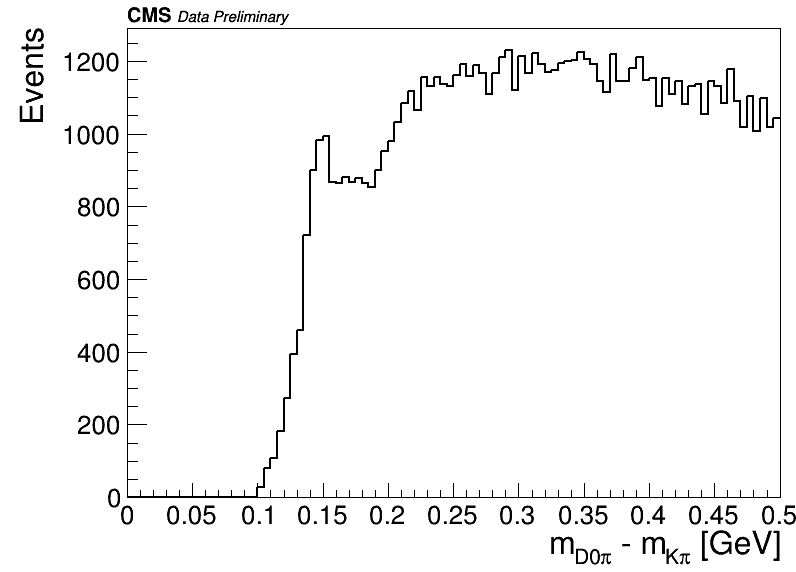

In [21]:
h = create_TH1D(dRD['mass_D0pis']-dRD['mass_kpi'], axis_title=['m_{D0#pi} - m_{K#pi} [GeV]', 'Events'], binning=[100,0.,.5])
CMS_lumi.extraText = "     Data Preliminary"
c = drawOnCMSCanvas([h])